<a href="https://colab.research.google.com/github/raqgmar/tsa4dst/blob/main/02_01_SVR_20240510.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
tfm_path='/content/drive/MyDrive/TFM data/'
H1_code = 'OMNI2_H0_MRG1HR'
M5_code = 'OMNI_HRO2_5MIN'
lookback = 1
lookforward = 1
cols_to_use = ['Bx', 'By_gse', 'Bz_gse', 'By_gsm', 'Bz_gsm', 'P_density', 'AP', 'E_field', 'plasma_T', 'plasma_V', 'Dst']
col_to_predict = "Dst"
hstorms_data = 'historical_storms_gruet2018.csv'
weak_threshold = -30 #1
moderate_threshold = -50 #2
strong_threshold = -100 #3
severe_threshold = -200 #4
great_threshold = -300 #5
temporal_margin=5*24 # margen para obtener tiempos ampliados de las tormentas d gruet et al 2018

---

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!rm -rf sample_data/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_log_error, median_absolute_error
from sklearn.metrics import explained_variance_score, max_error


# timer
import time

In [141]:
def filter_storms(df, historical_storms):
  all_storms = []
  for i in range(len(historical_storms)):
    # print(historical_storms.iloc[i]["start"])
    df_tmp = df[(df["Datetime"]>=historical_storms.iloc[i]["start"]) & (df["Datetime"]<=historical_storms.iloc[i]["end"])]
    idx = df_tmp['Dst'].idxmin()
    all_storms.append(df.iloc[idx-temporal_margin:idx+temporal_margin])
  return all_storms

def combinar_dataframes_solapados(dfs):
    # Ordenar la lista de DataFrames por la fecha mínima
    dfs.sort(key=lambda x: x['Datetime'].min())

    # Lista para guardar los DataFrames combinados
    combinados = []

    # DataFrame temporal para la combinación actual
    combinacion_actual = dfs[0]

    for df in dfs[1:]:
        # Comprobar si hay solapamiento
        if df['Datetime'].min() <= combinacion_actual['Datetime'].max():
            # Hay solapamiento, combinar los DataFrames
            combinacion_actual = pd.concat([combinacion_actual, df]).drop_duplicates().sort_values(by='Datetime')
        else:
            # No hay solapamiento, guardar el DataFrame combinado anterior y empezar uno nuevo
            combinados.append(combinacion_actual)
            combinacion_actual = df

    # Añadir el último DataFrame procesado a la lista
    combinados.append(combinacion_actual)

    return combinados

def scale_data(list_dfs):
  list_dfs_ = []
  scaler_cols = StandardScaler()
  scaler_label = StandardScaler()
  scaler_cols.fit(pd.concat(list_dfs)[cols_to_use])
  scaler_label.fit(np.asarray(pd.concat(list_dfs)[col_to_predict]).reshape(-1,1))

  for df_ in list_dfs:
    df = df_.copy()
    df[cols_to_use] = scaler_cols.transform(df[cols_to_use])
    list_dfs_.append(df)

  return list_dfs_, scaler_label


# scaler.inverse_transform(scaled_data)
def create_window_df_svr(list_dfs, scaler_label=None):
  x_train, y_train = [], []

  for df_ in list_dfs:
    df = df_.copy()
    df.interpolate(method='linear', inplace=True)
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    for i in range(len(df) - lookback - lookforward + 1):
      x_train.append(np.asarray(df.iloc[i:i+lookback][cols_to_use].values))
      y_train.append(np.asarray(df.iloc[i+lookback][col_to_predict]))

  if scaler_label is not None:
    y_train = scaler_label.inverse_transform(np.asarray(y_train).reshape(-1,1))

  print(np.asarray(x_train).shape, np.asarray(y_train).shape)
  return np.asarray(x_train), np.asarray(y_train)

In [145]:
all_storms = filter_storms(df, historical_storms)
all_storms = combinar_dataframes_solapados(all_storms)
all_storms, scaler_target = scale_data(all_storms)
x_all, y_all = create_window_df_svr(all_storms, scaler_target) # desescalado
# x_all, y_all = create_window_df_svr(all_storms) # sin desescalar

(10744, 1, 11) (10744, 1)


In [146]:
y_all

array([[ -7.],
       [ -5.],
       [ -2.],
       ...,
       [-38.],
       [-37.],
       [-36.]])

In [6]:
hd = pd.read_csv(tfm_path+H1_code+'.csv', parse_dates=["Datetime"])
# md = pd.read_csv(tfm_path+M5_code+'.csv', parse_dates=["Datetime"])
historical_storms = pd.read_csv(tfm_path+hstorms_data)
historical_storms = historical_storms.drop(columns=['Min. Dst (nT)','Unnamed: 0'], axis=1)

In [8]:
# # Ordenar los dataframes por fecha
historical_storms = historical_storms.sort_values(by='start')
hd['Datetime']=pd.to_datetime(hd['Datetime'])
historical_storms['start']=pd.to_datetime(historical_storms['start'])
historical_storms['end']=pd.to_datetime(historical_storms['end'])
# Unir basado en la condición de fecha
hd = pd.merge_asof(hd.sort_values('Datetime'), historical_storms, left_on='Datetime', right_on='start', direction='forward')

# Filtrar para asegurar que la fecha de 'hmd' está dentro del intervalo start y end
hd['storm'] = hd.apply(lambda row: row['storm'] if row['Datetime'] <= row['end'] else None, axis=1)

# Limpiar el DataFrame resultante si es necesario
hd = hd.drop(columns=['start', 'end'])

In [ ]:
#data = pd.merge(md, hd[["Datetime", "Dst"]], on='Datetime', how='left')

In [12]:
data = hd

In [13]:
print("Ya tenemos un pandas dataframe: str(type(data))="+str(type(data)))

Ya tenemos un pandas dataframe: str(type(data))=<class 'pandas.core.frame.DataFrame'>


Input X contains NaN. Por tanto, tenemos que hacer imputación de nulos.

## Imputación de valores nulos

In [14]:
total_rows = len(data)
null_counts = data.isnull().sum()
null_percentage = (null_counts / total_rows) * 100
print(null_percentage)

ID_IMF            0.000000
ID_plasma         0.102679
Bmag              0.000000
dev_Bmag          0.000000
Bx                0.000000
By_gse            0.000000
Bz_gse            0.000000
By_gsm            0.000000
Bz_gsm            0.000000
dev_Bx            0.000000
dev_By            0.000000
dev_Bz            0.000000
P_density         2.773975
dev_P_density     2.773975
AP               11.977639
dev_AP           11.977639
E_field           0.102679
plasma_T          2.399928
dev_plasma_T      2.399928
plasma_V          0.102679
Dst               0.000000
Datetime          0.000000
storm             6.186844
dtype: float64


In [29]:
df['storm'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 122712 entries, 0 to 122711
Series name: storm
Non-Null Count   Dtype  
--------------   -----  
115120 non-null  float64
dtypes: float64(1)
memory usage: 958.8 KB


In [16]:
df = data

In [22]:
df.columns

Index(['ID_IMF', 'ID_plasma', 'Bmag', 'dev_Bmag', 'Bx', 'By_gse', 'Bz_gse',
       'By_gsm', 'Bz_gsm', 'dev_Bx', 'dev_By', 'dev_Bz', 'P_density',
       'dev_P_density', 'AP', 'dev_AP', 'E_field', 'plasma_T', 'dev_plasma_T',
       'plasma_V', 'Dst', 'Datetime', 'storm'],
      dtype='object')

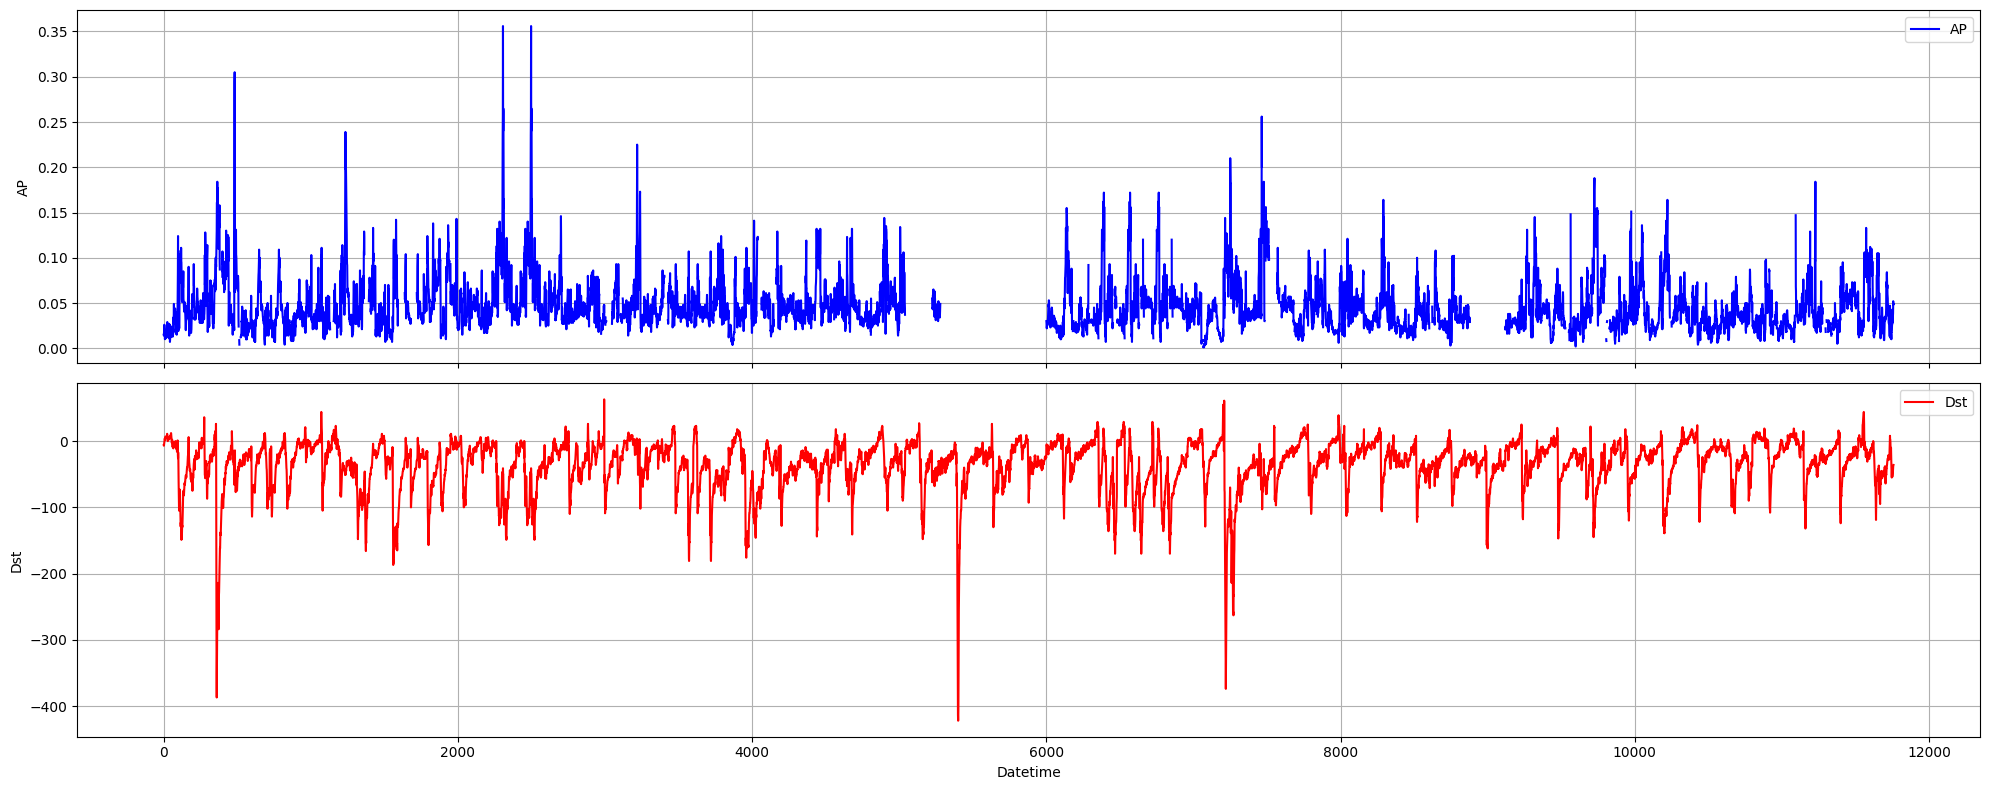

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it's already loaded with data


# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20, 8))

df_plot.reset_index(inplace=True)
# Plotting 'AP' on the first subplot
ax1.plot(df_plot.index, df_plot['AP'], label='AP', color='blue')
ax1.set_ylabel('AP')
ax1.legend(loc='upper right')
ax1.grid(True)

# Plotting 'Dst' on the second subplot
ax2.plot(df_plot.index, df_plot['Dst'], label='Dst', color='red')
ax2.set_ylabel('Dst')
ax2.legend(loc='upper right')
ax2.grid(True)

# Setting the x-axis label only on the bottom subplot
ax2.set_xlabel('Datetime')

# Improve layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
data.interpolate(method='linear', inplace=True)

print(data.isnull().sum())

## Obtain train and test data.

In [ ]:
# Preprocessing
X = data[cols_to_use]
y = data[col_to_predict]


# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
type(X_train)

In [ ]:
def calc_metrics(predictions, y_test):
  # Mean Squared Error
  mse = mean_squared_error(y_test, predictions)
  # Mean Absolute Error
  mae = mean_absolute_error(y_test, predictions)
  # R^2 Score, the coefficient of determination
  r2 = r2_score(y_test, predictions)
  # Mean Squared Logarithmic Error
  msle = mean_squared_log_error(y_test, predictions)
  # Median Absolute Error
  medae = median_absolute_error(y_test, predictions)
  # Explained Variance Score
  explained_variance = explained_variance_score(y_test, predictions)
  # Max Error
  max_err = max_error(y_test, predictions)

  return mse, mae, r2, msle, medae, explained_variance, max_err


In [ ]:
def formatear_tiempo(segundos):
    horas = int(segundos // 3600)
    minutos = int((segundos % 3600) // 60)
    segundos = segundos % 60
    return f"{horas} horas, {minutos} minutos, {segundos:.2f} segundos"

## Linear

In [ ]:
# # Model
# kernels = ['linear', 'poly', 'rbf', 'sigmoid']
# mse_list = []
# mae_list = []
# r2_list = []
# msle_list = []
# medae_list = []
# exp_var_list = []
# max_err_list = []
# time_list = []

# for kernel_ in kernels:
#   start = time.time()
#   print("Starting {}".format(kernel_))
#   if kernel_ == "linear":
#     model = SVR(kernel='linear', C=1.0, epsilon=0.1, gamma='auto')
#   elif kernel_ == "poly":
#     model = SVR(kernel='poly', C=1.0, epsilon=0.1, gamma='auto', degree=3)  # Degree is optional, default is 3
#   elif kernel_ == "rbf":
#     model = SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma='auto')
#   elif kernel_ == "sigmoid":
#     model = SVR(kernel='sigmoid', C=1.0, epsilon=0.1, gamma='auto')
#   elif kernel_ == "precomputed":
#     # Note: For kernel='precomputed', you need to supply a precomputed kernel matrix instead of X_train
#     # Here's a placeholder assuming precomputed_matrix is already defined
#     model = SVR(kernel='precomputed', C=1.0, epsilon=0.1)
#     if 'precomputed_matrix' in locals():
#       model.fit(precomputed_matrix, y_train)
#       continue  # Skip the rest of the loop if using precomputed kernel
#     else:
#       print("Precomputed matrix not defined for kernel='precomputed'")
#       continue

#   # Fit the model on training data
#   model.fit(X_train, y_train)
#   # Prediction and Evaluation
#   predictions = model.predict(X_test)

#   mse, mae, r2, msle, medae, explained_variance, max_err = calc_metrics(predictions, y_test)
#   mse_list.append(mse)
#   mae_list.append(mae)
#   r2_list.append(r2)
#   msle_list.append(msle)
#   medae_list.append(medae)
#   exp_var_list.append(explained_variance)
#   max_err_list.append(max_err)

#   end = time.time()
#   time_exec = formatear_tiempo(end-start)
#   time_list.append(time_exec)
#   print("{} finished. Time for iteration: {}".format(kernel_, time_exec))



# df_results = pd.DataFrame(
#     {
#         "kernel": kernels,
#         "mse": mse_list,
#         "mae": mae_list,
#         "r2": r2_list,
#         "msle": msle_list,
#         "medae": medae_list,
#         "exp_var": exp_var_list,
#         "max_err": max_err_list,
#         "time_exec": time_list
#     }

# )

# df_results